In [1]:
import numpy as np
import mne
import pickle
import matplotlib
from mne.preprocessing import read_ica
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC, SVR

from tqdm import tqdm
from matplotlib import pyplot as plt

from continuous_control_bci.visualisation.erds import plot_tfr
from continuous_control_bci.util import emg_classes_to_eeg_classes, SUBJECT_IDS
from continuous_control_bci.data.load_data import load_calibration, load_driving
from continuous_control_bci.data.preprocessing import make_epochs, epochs_to_train_test
from continuous_control_bci.data.emg_events import make_rough_emg_events
from continuous_control_bci.modelling.csp_classifier import create_csp_classifier, get_driving_epochs_for_csp
from sklearn.metrics import f1_score
from filterbank_csp import filter_bank, filter_bank_csp, predict_against_threshold, predict_against_threshold_indiv, create_csp_svm_classifier, majority_pred

# This notebook tries to find if there is a difference in the Patterns found in Calibration and Driving data
- erds
- psd
- features used

In [4]:
subject_id = "061"
include_rest = True
if include_rest:
    target_names = ["Left", "Right", "Rest"]
else:
    target_names = ["Left", "Right"]
#raw = load_calibration(subject_id)
#raw.set_eeg_reference()
#raw.filter(l_freq=5, h_freq=35)
#eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False)
#ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
#ica.apply(raw)
#epochs = make_epochs(raw, include_rest=include_rest)
#X_train, _, y_train, _ = epochs_to_train_test(epochs)

In [12]:
subject_ids = ['061', '381', '812']
for subject_id in subject_ids:
    tmin = -3.0
    tmax = 5.0
    buffer = 0.5
    event_ids = dict(left=0, right=1)
    raw = load_calibration(subject_id)
    raw.set_eeg_reference()
    raw.filter(l_freq=1, h_freq=35)

    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(raw)

    raw = mne.preprocessing.compute_current_source_density(raw)

    matplotlib.use('Agg')

    epochs = make_epochs(raw, tmin=tmin-buffer, tmax=tmax+buffer, include_rest=False)
    #epochs.compute_psd(fmin=6, fmax=15, exclude='bads', picks='eeg', method='welch').plot(average=True)
    epochs.pick(["C3", "C4"])

    plot_tfr(epochs, subject_id, baseline=(-3, 0), tmin=tmin, tmax=tmax, event_ids=event_ids, kind='calibration')
    plot_tfr(epochs, subject_id, baseline=None, tmin=tmin, tmax=tmax, event_ids=event_ids, kind='calibration')

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 18433 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s finished


Using a threshold of 1.729133
stat_fun(H1): min=-12.506708 max=4.328186
Running initial clustering …
Found 61 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-12.506708 max=4.328186
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-36.066891 max=3.485070
Running initial clustering …
Found 35 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-36.066891 max=3.485070
Running initial clustering …
Found 62 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-13.117535 max=3.765051
Running initial clustering …
Found 54 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-13.117535 max=3.765051
Running initial clustering …
Found 79 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-8.420235 max=4.550577
Running initial clustering …
Found 64 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-8.420235 max=4.550577
Running initial clustering …
Found 73 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P381\motor-imagery-csp-381-acquisition-[2024.02.09-09.37.02].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882655  =      0.000 ...   430.984 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 18433 original time points ...
    Rejecting  epoch based on CSD : ['F7']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC5', 'T7', 'CP5']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC5', 'T7']
3 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished


Using a threshold of 1.734064
stat_fun(H1): min=-15.075574 max=3.578403
Running initial clustering …
Found 67 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.734064
stat_fun(H1): min=-15.075574 max=3.578403
Running initial clustering …
Found 55 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.734064
stat_fun(H1): min=-53.699301 max=3.752157
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.734064
stat_fun(H1): min=-53.699301 max=3.752157
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-132.004093 max=3.684832
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.739607
stat_fun(H1): min=-132.004093 max=3.684832
Running initial clustering …
Found 59 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.739607
stat_fun(H1): min=-15.991370 max=3.964917
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.739607
stat_fun(H1): min=-15.991370 max=3.964917
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P812\motor-imagery-csp-812-acquisition-[2024.01.29-11.21.29].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882815  =      0.000 ...   431.062 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 18433 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished


Using a threshold of 1.729133
stat_fun(H1): min=-35.777253 max=3.702470
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-35.777253 max=3.702470
Running initial clustering …
Found 73 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-20.831057 max=2.788593
Running initial clustering …
Found 25 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-20.831057 max=2.788593
Running initial clustering …
Found 69 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-70.396352 max=2.438518
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-70.396352 max=2.438518
Running initial clustering …
Found 45 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.729133
stat_fun(H1): min=-19.649199 max=3.635044
Running initial clustering …
Found 49 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.729133
stat_fun(H1): min=-19.649199 max=3.635044
Running initial clustering …
Found 73 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


Not setting metadata
No baseline correction applied


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied


In [18]:
subject_ids = ['061', '381', '812']
for subject_id in subject_ids:
    tmin = -3
    tmax = 5
    buffer = 0.5
    time_offset = 1.25
    event_ids = dict(left=-1, right=1)
    driving_recording = load_driving(subject_id)
    driving_recording.raw.set_eeg_reference()

    driving_recording.raw.filter(l_freq=1, h_freq=35)

    ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
    ica.apply(driving_recording.raw)

    driving_recording.raw = mne.preprocessing.compute_current_source_density(driving_recording.raw)


    matplotlib.use('Agg')
    events = make_rough_emg_events(driving_recording.eeg_stream, driving_recording.emg_prediction_stream)

    reject_threshold = 100e-3
    epochs = mne.Epochs(
        driving_recording.raw,
        events,
        event_ids,
        tmin=tmin - buffer - time_offset,
        tmax=tmax + buffer - time_offset,
        reject={"csd": reject_threshold},
        baseline=None,
        preload=True,
    )

    epochs.pick(["C3", "C4"])
    epochs.shift_time(time_offset)

    event_ids = dict(left=-1, right=1)
    plot_tfr(epochs, subject_id, baseline=(-3, 0), tmin=tmin, tmax=tmax, event_ids=event_ids, kind='driving')
    plot_tfr(epochs, subject_id, baseline=None, tmin=tmin, tmax=tmax, event_ids=event_ids, kind='driving')

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.0s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 97 events and 18433 original time points ...
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'F8']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'FC5', 'T7', 'F8', 'Fp2']
    Rejecting  epoch based on CSD : ['T7', 'CP5', 'P8', 'CP6', 'C4', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Oz', 'F8', 'Fp2']
    Reje

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s finished


Applying baseline correction (mode: percent)
Using a threshold of 1.672522
stat_fun(H1): min=-4.591227 max=5.820745
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.672522
stat_fun(H1): min=-4.591227 max=5.820745
Running initial clustering …
Found 46 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.672522
stat_fun(H1): min=-7.165887 max=2.557890
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.672522
stat_fun(H1): min=-7.165887 max=2.557890
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.692360
stat_fun(H1): min=-18.741274 max=2.589136
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.692360
stat_fun(H1): min=-18.741274 max=2.589136
Running initial clustering …
Found 83 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.692360
stat_fun(H1): min=-4.118174 max=7.674919
Running initial clustering …
Found 39 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.692360
stat_fun(H1): min=-4.118174 max=7.674919
Running initial clustering …
Found 41 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    6.2s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Creating RawArray with float64 data, n_channels=40, n_times=5313379
    Range : 0 ... 5313378 =      0.000 ...  2594.423 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.6s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P381-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Not setting metadata
82 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 82 events and 18433 original time points ...
    Rejecting  epoch based on CSD : ['FC1']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P3', 'PO3', 'P4', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz']
    Rejecting  epoch based on CSD : ['F7', 'FC5', 'T7', 'C3', 'CP5', 'P7', 'P3', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'Fp2']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3']
4 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.9s finished


Applying baseline correction (mode: percent)
Using a threshold of 1.674689
stat_fun(H1): min=-3.537488 max=5.388195
Running initial clustering …
Found 46 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.674689
stat_fun(H1): min=-3.537488 max=5.388195
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.674689
stat_fun(H1): min=-5.345171 max=4.934565
Running initial clustering …
Found 24 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.674689
stat_fun(H1): min=-5.345171 max=4.934565
Running initial clustering …
Found 57 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.710882
stat_fun(H1): min=-8.757973 max=3.081281
Running initial clustering …
Found 31 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.710882
stat_fun(H1): min=-8.757973 max=3.081281
Running initial clustering …
Found 68 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.710882
stat_fun(H1): min=-5.315779 max=4.673157
Running initial clustering …
Found 57 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.710882
stat_fun(H1): min=-5.315779 max=4.673157
Running initial clustering …
Found 39 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied
Creating RawArray with float64 data, n_channels=40, n_times=5750675
    Range : 0 ... 5750674 =      0.000 ...  2807.946 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    9.4s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P812-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Not setting metadata
116 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 116 events and 18433 original time points ...
    Rejecting  epoch based on CSD : ['T7', 'CP5', 'Oz']
5 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.1s finished


Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.663649
stat_fun(H1): min=-3.403843 max=6.464097
Running initial clustering …
Found 32 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.663649
stat_fun(H1): min=-3.403843 max=6.464097
Running initial clustering …
Found 36 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.663649
stat_fun(H1): min=-11.412359 max=5.250405
Running initial clustering …
Found 29 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.663649
stat_fun(H1): min=-11.412359 max=5.250405
Running initial clustering …
Found 44 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.703288
stat_fun(H1): min=-13.381568 max=5.427219
Running initial clustering …
Found 48 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.703288
stat_fun(H1): min=-13.381568 max=5.427219
Running initial clustering …
Found 56 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.703288
stat_fun(H1): min=-3.960820 max=5.218850
Running initial clustering …
Found 72 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.703288
stat_fun(H1): min=-3.960820 max=5.218850
Running initial clustering …
Found 58 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


In [17]:
subject_id = "061"
tmin = -3
tmax = 5
buffer = 0.5
time_offset = 1.25
event_ids = dict(left=-1, right=1)
driving_recording = load_driving(subject_id)
driving_recording.raw.set_eeg_reference()

driving_recording.raw.filter(l_freq=1, h_freq=35)

ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(driving_recording.raw)

driving_recording.raw = mne.preprocessing.compute_current_source_density(driving_recording.raw)

matplotlib.use('Agg')
events = make_rough_emg_events(driving_recording.eeg_stream, driving_recording.emg_prediction_stream)

reject_threshold = 100e-3
epochs = mne.Epochs(
    driving_recording.raw,
    events,
    event_ids,
    tmin=tmin - buffer - time_offset,
    tmax=tmax + buffer - time_offset,
    reject={"csd": reject_threshold},
    baseline=None,
    preload=True,
)

epochs.pick(["C3", "C4"])
epochs.shift_time(time_offset)

event_ids = dict(left=-1, right=1)
plot_tfr(epochs, subject_id, baseline=(-3, 0), tmin=tmin, tmax=tmax, event_ids=event_ids, kind='driving')
plot_tfr(epochs, subject_id, baseline=None, tmin=tmin, tmax=tmax, event_ids=event_ids, kind='driving')

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.1s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Fitted sphere radius:         95.0 mm
Origin head coordinates:      0.0 -0.0 40.1 mm
Origin device coordinates:    0.0 -0.0 40.1 mm
Not setting metadata
97 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 97 events and 18433 original time points ...
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'F8']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'FC5', 'T7', 'F8', 'Fp2']
    Rejecting  epoch based on CSD : ['T7', 'CP5', 'P8', 'CP6', 'C4', 'T8', 'FC6', 'F8']
    Rejecting  epoch based on CSD : ['Fp1', 'AF3', 'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5', 'P7', 'P3', 'Oz', 'F8', 'Fp2']
    Reje

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s finished


Applying baseline correction (mode: percent)
Using a threshold of 1.672522
stat_fun(H1): min=-4.591227 max=5.820745
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.672522
stat_fun(H1): min=-4.591227 max=5.820745
Running initial clustering …
Found 46 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.672522
stat_fun(H1): min=-7.165887 max=2.557890
Running initial clustering …
Found 28 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.672522
stat_fun(H1): min=-7.165887 max=2.557890
Running initial clustering …
Found 80 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 2 clusters to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.692360
stat_fun(H1): min=-18.741274 max=2.589136
Running initial clustering …
Found 16 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.692360
stat_fun(H1): min=-18.741274 max=2.589136
Running initial clustering …
Found 83 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.692360
stat_fun(H1): min=-4.118174 max=7.674919
Running initial clustering …
Found 39 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.692360
stat_fun(H1): min=-4.118174 max=7.674919
Running initial clustering …
Found 41 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.0s finished


No baseline correction applied
No baseline correction applied
No baseline correction applied
No baseline correction applied


### Looking at CSP patterns
Calib:

In [21]:
subject_id = "061"
include_rest = True
if include_rest:
    target_names = ["Left", "Right", "Rest"]
else:
    target_names = ["Left", "Right"]
raw = load_calibration(subject_id)
raw.set_eeg_reference()
raw.filter(l_freq=5, h_freq=35)
eeg_channel_indices = mne.pick_types(raw.info, eeg=True, emg=False, eog=False)
raw.pick(picks=eeg_channel_indices)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(raw)
epochs = make_epochs(raw, include_rest=include_rest)
X_train, _, y_train, _ = epochs_to_train_test(epochs)
iir_params = dict(order=4, ftype="butterworth", output='sos')
#iir_params = mne.filter.construct_iir_filter(iir_params, f_pass=[8,11], sfreq=2048, btype="bandpass")
X_train = mne.filter.filter_data(X_train, 2048, l_freq=9, h_freq=11,method='iir', iir_params=iir_params)
rank = {
    'eeg': X_train.shape[1] - len(ica.exclude),
    'mag': 32,
}
clf, y_pred = create_csp_classifier(X_train, y_train, rank)

Extracting EDF parameters from D:\RUG\Term 2\FYRP\data\ivo_data\sub-P061\motor-imagery-csp-061-acquisition-[2024.02.07-14.35.15].gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
Channel 1, Channel 2, Channel 3, Channel 4, Channel 5, Channel 6, Channel 7, Channel 8, Channel 9, Channel 10, Channel 11, Channel 12, Channel 13, Channel 14, Channel 15, Channel 16, Channel 17, Channel 18, Channel 19, Channel 20, Channel 21, Channel 22, Channel 23, Channel 24, Channel 25, Channel 26, Channel 27, Channel 28, Channel 29, Channel 30, Channel 31, Channel 32, EX 1, EX 2, EX 3, EX 4, EX 5, EX 6, EX 7, EX 8
Creating raw.info structure...
Reading 0 ... 882783  =      0.000 ...   431.046 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter paramete

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.4s finished


    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Used Annotations descriptions: ['769', '770']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['800']
Not setting metadata
40 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 40 events and 7681 original time points ...
0 bad epochs dropped
Not setting metadata
80 matching events found
No baseline correction applied
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB



D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)
D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\preprocessing.py:83: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs([epochs, rest_epochs], add_offset=False)


Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covariance using SHRINKAGE
Done.
Computing rank from data with rank={'eeg': 30

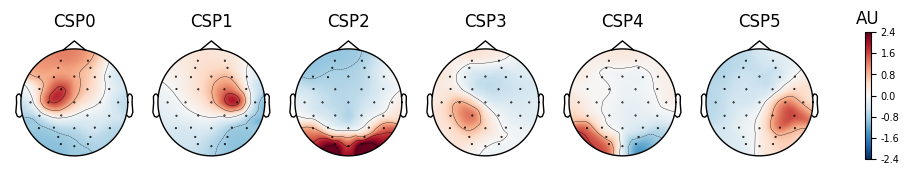

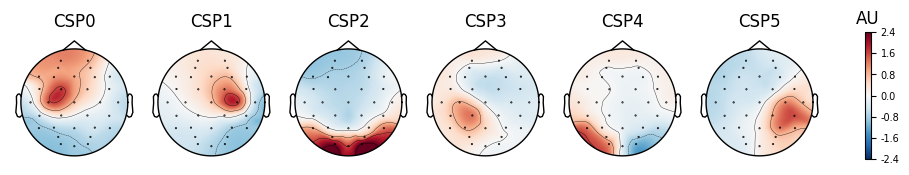

In [22]:
clf['CSP'].plot_patterns(epochs.info)

In [ ]:
clf['CSP'].plot_filters(epochs.info)

Driving CSP:

Creating RawArray with float64 data, n_channels=40, n_times=5494682
    Range : 0 ... 5494681 =      0.000 ...  2682.950 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


D:\RUG\Term 2\FYRP\FYRP\continuous_control_bci\data\load_data.py:28: RuntimeWarning: The unit for channel(s) AF3, AF4, C3, C4, CP1, CP2, CP5, CP6, Cz, F3, F4, F7, F8, FC1, FC2, FC5, FC6, Fp1, Fp2, Fz, LHEOG, LVEOG, Left-extension, Left-flexion, O1, O2, Oz, P3, P4, P7, P8, PO3, PO4, Pz, RHEOG, Right-extension, Right-flexion, T7, T8, UVEOG has changed from NA to V.
  streams.raw.set_channel_types(CHANNEL_TYPE_MAPPING)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 4.00 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 3381 samples (1.651 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    3.9s finished


Reading D:/RUG/Term 2/FYRP/data/ica/P061-calibration-ica.fif ...
Now restoring ICA solution ...
Ready.
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 32 PCA components
Not setting metadata
13405 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 13405 events and 4096 original time points ...
0 bad epochs dropped
Setting up band-pass filter from 9 - 11 Hz

IIR filter parameters
---------------------
butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 9.00, 11.00 Hz: -6.02, -6.02 dB

Shape of y_driving before adjusting (13415,)
Shape of X_driving before adjustment (13405, 32, 2048)
Computing rank from data with rank={'eeg': 30, 'mag': 32}
    Setting small MAG eigenvalues to zero (without PCA)
Reducing data rank from 32 -> 32
Estimating covari

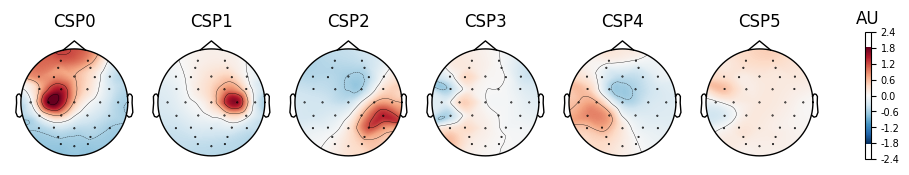

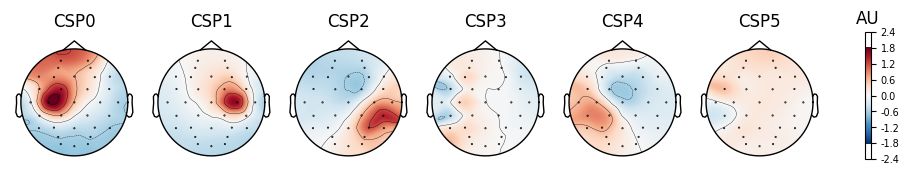

In [23]:
filters = [[9,11], [9,11], [10,12]]
subject_id = "061"
include_rest = True
iir_params = dict(order=4, ftype="butterworth", output='sos')
driving = load_driving(subject_id)
driving.raw.set_eeg_reference()
driving.raw.filter(l_freq=5, h_freq=35)
ica = read_ica(f'D:/RUG/Term 2/FYRP/data/ica/P{subject_id}-calibration-ica.fif')
ica.apply(driving.raw)

# EEG Data Stream
eeg_channel_indices = mne.pick_types(driving.raw.info, eeg=True, emg=False)
eeg_data, eeg_time = driving.raw[eeg_channel_indices]
# Those windows are basically my epochs on which I try to predict something, if a certain amount of windows have the same prediction (3.5 sec or smth) this can then be used to controll the car
eeg_windows = mne.make_fixed_length_epochs(driving.raw, duration=2,overlap=1.8, preload=True, reject_by_annotation=False)
eeg_windows = eeg_windows.resample(1024)
X_driving = eeg_windows.get_data(copy=False, picks=eeg_channel_indices)
X_driving = mne.filter.filter_data(X_driving, 1024, l_freq=filters[0][0], h_freq=filters[0][1],method='iir', iir_params=iir_params)


# EMG Stream
# -1 left, 0 rest, 1 right
y_driving = driving.emg_prediction_stream['time_series']
y_driving = emg_classes_to_eeg_classes(y_driving)
# 0 left, 1 right, 2 rest
y_driving = np.squeeze(y_driving)
print("Shape of y_driving before adjusting",y_driving.shape)
print("Shape of X_driving before adjustment", X_driving.shape)
if X_driving.shape[0] == y_driving.shape[0]:
    pass
elif X_driving.shape[0] > y_driving.shape[0]:
    diff = X_driving.shape[0]-y_driving.shape[0]
    X_driving = X_driving[:-diff,:,:]
else:
    diff = y_driving.shape[0]-X_driving.shape[0]
    y_driving = y_driving[:-diff]
    rank = {
        'eeg': X_driving.shape[1] - len(ica.exclude),
        'mag': 32,
    }
clf, y_driving_pred = create_csp_classifier(X_driving, y_driving, rank)

clf['CSP'].plot_patterns(epochs.info)

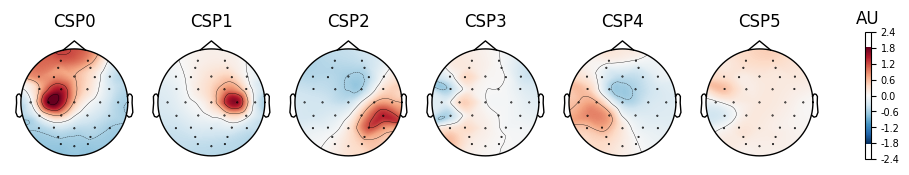

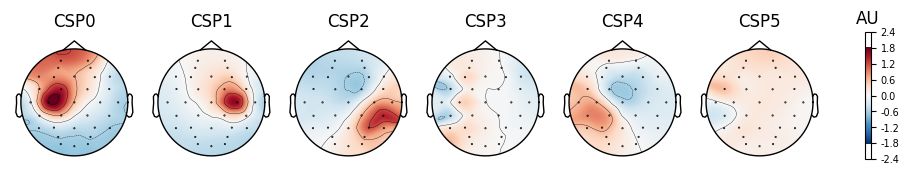

In [34]:
clf['CSP'].plot_patterns(epochs.info)


<Figure size 640x480 with 0 Axes>

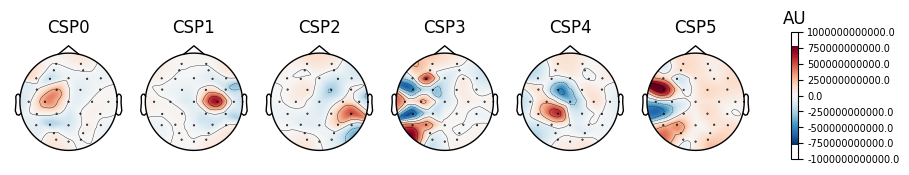

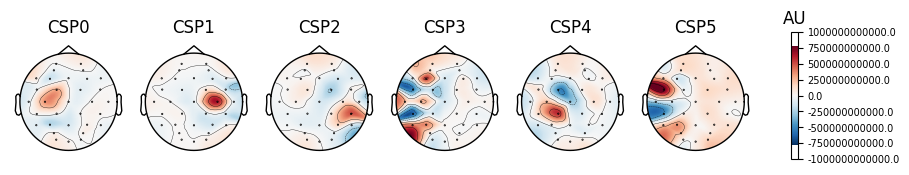

In [26]:
clf['CSP'].plot_filters(epochs.info)